In [ ]:
# Install kagglehub
!pip install kagglehub

# Import the library
import kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [ ]:
import os

data_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images"
print("Subfolders:", os.listdir(data_dir))

Subfolders: ['test', 'train']


In [ ]:
# See what's inside 'train' and 'test'
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

print("Train subfolders:", os.listdir(train_dir))
print("Test subfolders:", os.listdir(test_dir))

Train subfolders: ['FAKE', 'REAL']
Test subfolders: ['FAKE', 'REAL']


In [ ]:
from torchvision import datasets, transforms

# Define standard transforms
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"
test_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

print("Classes:", train_dataset.classes)
print("Number of training images:", len(train_dataset))
print("Number of test images:", len(test_dataset))

Classes: ['FAKE', 'REAL']
Number of training images: 100000
Number of test images: 20000


In [ ]:
from torch.utils.data import random_split

# How much for validation
val_ratio = 0.1
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size

train_data, val_data = random_split(train_dataset, [train_size, val_size])
print(f"Train: {len(train_data)}, Val: {len(val_data)}")

Train: 90000, Val: 10000


In [ ]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches: 2813
Val batches: 313
Test batches: 625


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CustomCNN(num_classes=2)
print(model)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
!pip install tqdm

In [ ]:
from tqdm.auto import tqdm

num_epochs = 10

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

Epoch 1/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.4297 Acc: 0.8051 | Val Loss: 0.3240 Acc: 0.8583


Epoch 2/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.3287 Acc: 0.8614 | Val Loss: 0.3022 Acc: 0.8704


Epoch 3/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.2906 Acc: 0.8812 | Val Loss: 0.2528 Acc: 0.8946


Epoch 4/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.2610 Acc: 0.8951 | Val Loss: 0.2500 Acc: 0.8963


Epoch 5/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.2447 Acc: 0.9019 | Val Loss: 0.2371 Acc: 0.9047


Epoch 6/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.2313 Acc: 0.9076 | Val Loss: 0.2170 Acc: 0.9127


Epoch 7/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.2206 Acc: 0.9128 | Val Loss: 0.2177 Acc: 0.9091


Epoch 8/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.2138 Acc: 0.9159 | Val Loss: 0.1981 Acc: 0.9173


Epoch 9/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.2083 Acc: 0.9191 | Val Loss: 0.2080 Acc: 0.9144


Epoch 10/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 0.2036 Acc: 0.9211 | Val Loss: 0.2015 Acc: 0.9227


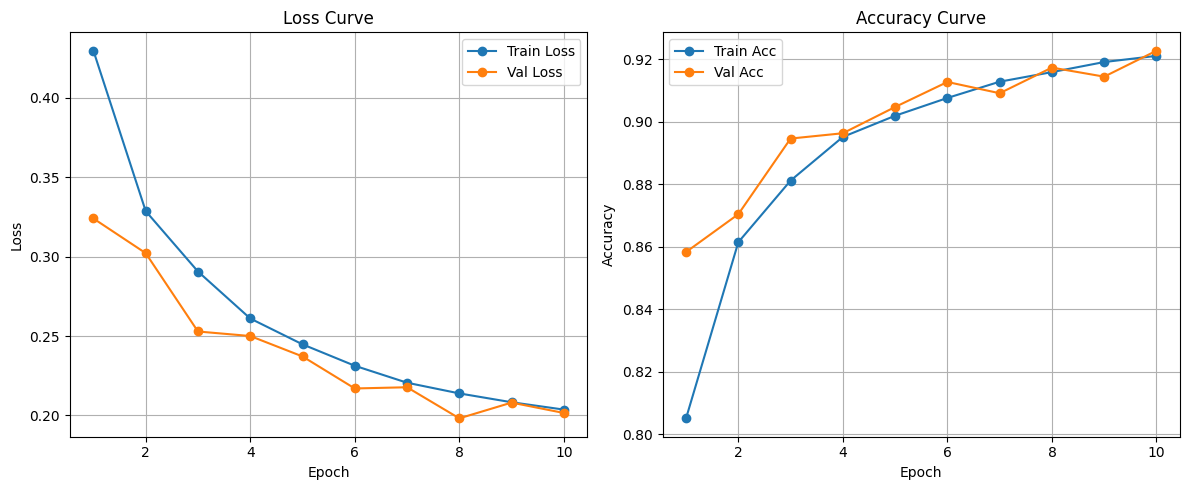

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, marker='o', label='Train Acc')
plt.plot(epochs, val_accs, marker='o', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / test_total
test_acc = test_correct / test_total

print(f"\nTest Loss: {avg_test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


Test Loss: 0.2022 | Test Accuracy: 0.9251

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.92      0.94      0.93     10000
        REAL       0.93      0.91      0.92     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

Confusion Matrix:
 [[9362  638]
 [ 860 9140]]


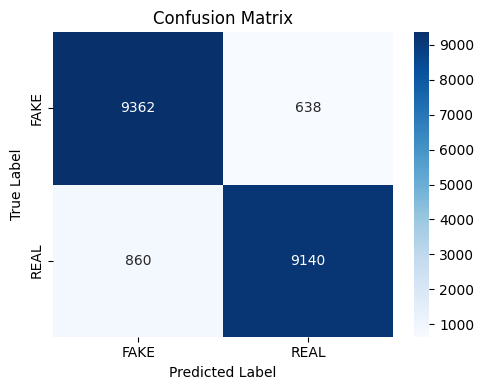

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

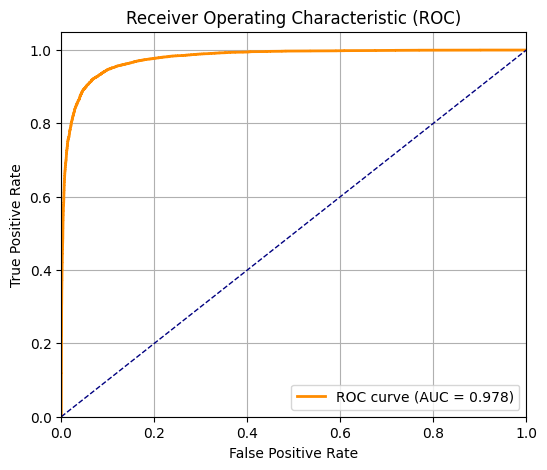

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (real)
model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of 'REAL'
        all_probs.extend(probs.cpu().numpy())

# True labels
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

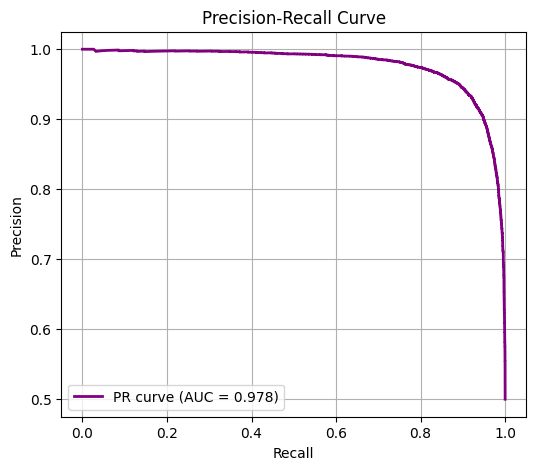

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = average_precision_score(all_labels, all_probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [ ]:
# Save the trained model's state_dict
model_path = "models/custom_cnn_cifake.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to custom_cnn_cifake.pth


In [ ]:
import pickle

logs = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accs": train_accs,
    "val_accs": val_accs
}

with open("training_logs_cifake.pkl", "wb") as f:
    pickle.dump(logs, f)

print("Training logs saved to training_logs_cifake.pkl")

Training logs saved to training_logs_cifake.pkl


#RESNET 18

In [ ]:
from torchvision import models
import torch.nn as nn

# Load pretrained ResNet18
resnet18 = models.resnet18(pretrained=True)

# Replace the final fully-connected layer for 2 classes
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)

resnet18 = resnet18.to(device)
print(resnet18)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.optim as optim

# Freeze all layers except the final fully-connected layer
for param in resnet18.parameters():
    param.requires_grad = False
for param in resnet18.fc.parameters():
    param.requires_grad = True

# Loss and optimizer
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet18.fc.parameters(), lr=0.001)

print("ResNet18 optimizer and loss function are set.")

ResNet18 optimizer and loss function are set.


In [ ]:
from tqdm.auto import tqdm

num_epochs_resnet = 10

train_losses_resnet, val_losses_resnet = [], []
train_accs_resnet, val_accs_resnet = [], []

for epoch in range(num_epochs_resnet):
    #Training
    resnet18.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs_resnet} [Train]"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer_resnet.zero_grad()
        outputs = resnet18(images)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses_resnet.append(epoch_loss)
    train_accs_resnet.append(epoch_acc)

    #Validation
    resnet18.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs_resnet} [Val]"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = resnet18(images)
            loss = criterion_resnet(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses_resnet.append(val_epoch_loss)
    val_accs_resnet.append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs_resnet} | "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

Epoch 1/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.3701 Acc: 0.8347 | Val Loss: 0.3063 Acc: 0.8698


Epoch 2/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.3422 Acc: 0.8512 | Val Loss: 0.3144 Acc: 0.8672


Epoch 3/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.3384 Acc: 0.8538 | Val Loss: 0.3090 Acc: 0.8673


Epoch 4/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.3369 Acc: 0.8542 | Val Loss: 0.2965 Acc: 0.8740


Epoch 5/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.3366 Acc: 0.8534 | Val Loss: 0.2991 Acc: 0.8725


Epoch 6/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.3380 Acc: 0.8535 | Val Loss: 0.2979 Acc: 0.8710


Epoch 7/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.3375 Acc: 0.8539 | Val Loss: 0.2947 Acc: 0.8729


Epoch 8/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.3339 Acc: 0.8549 | Val Loss: 0.3035 Acc: 0.8716


Epoch 9/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.3367 Acc: 0.8548 | Val Loss: 0.3209 Acc: 0.8647


Epoch 10/10 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 0.3348 Acc: 0.8550 | Val Loss: 0.2989 Acc: 0.8744


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

resnet18.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet18(images)
        loss = criterion_resnet(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # Prob of REAL

avg_test_loss = test_loss / test_total
test_acc = test_correct / test_total

print(f"\nTest Loss: {avg_test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

cm_resnet = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm_resnet)


Test Loss: 0.3374 | Test Accuracy: 0.8566

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.83      0.89      0.86     10000
        REAL       0.88      0.82      0.85     10000

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Confusion Matrix:
 [[8896 1104]
 [1764 8236]]


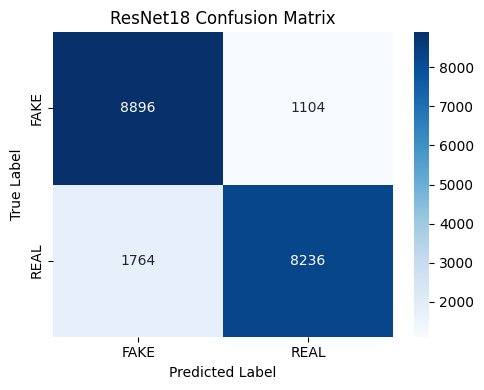

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ResNet18 Confusion Matrix')
plt.tight_layout()
plt.show()

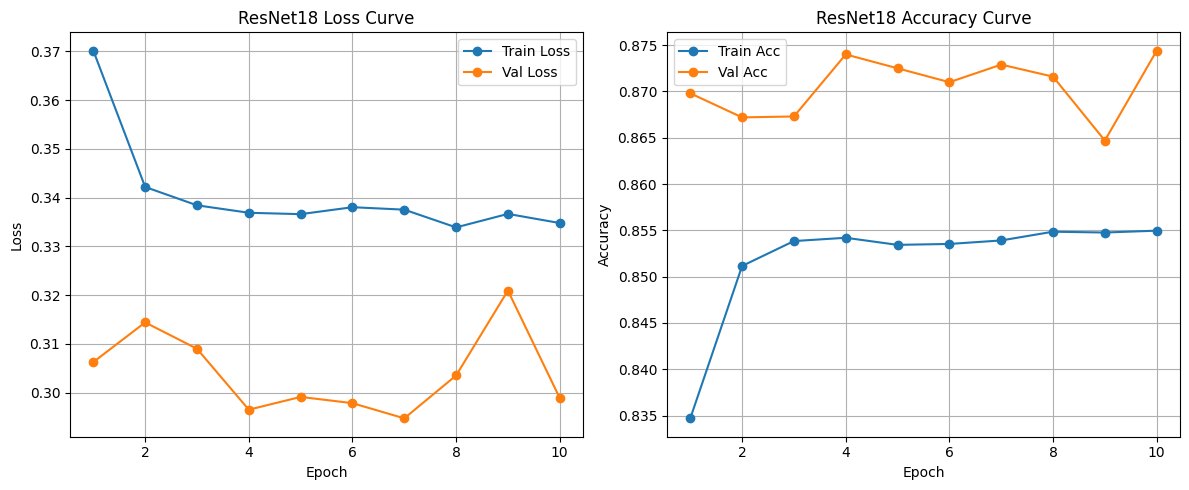

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses_resnet) + 1)

plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_resnet, marker='o', label='Train Loss')
plt.plot(epochs, val_losses_resnet, marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet18 Loss Curve')
plt.legend()
plt.grid(True)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs_resnet, marker='o', label='Train Acc')
plt.plot(epochs, val_accs_resnet, marker='o', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet18 Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

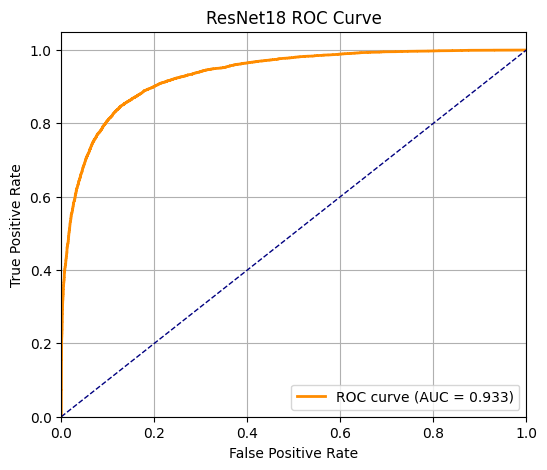

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet18 ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

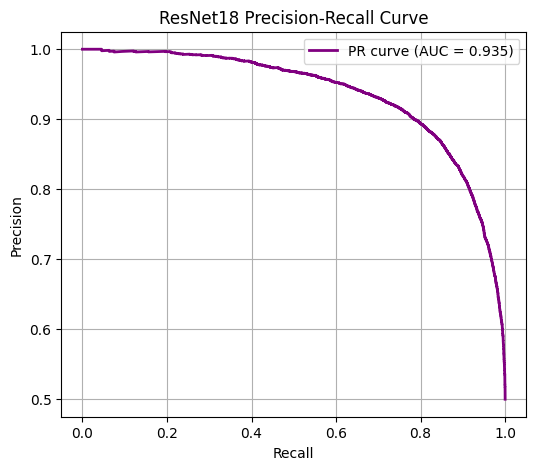

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(all_labels, all_probs)
pr_auc = average_precision_score(all_labels, all_probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('ResNet18 Precision-Recall Curve')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [ ]:
!pip install torchcam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install opencv-python

In [ ]:
from torchvision import datasets, transforms

test_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test"  # adjust if needed!

test_vis_dataset = datasets.ImageFolder(
    test_dir,
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

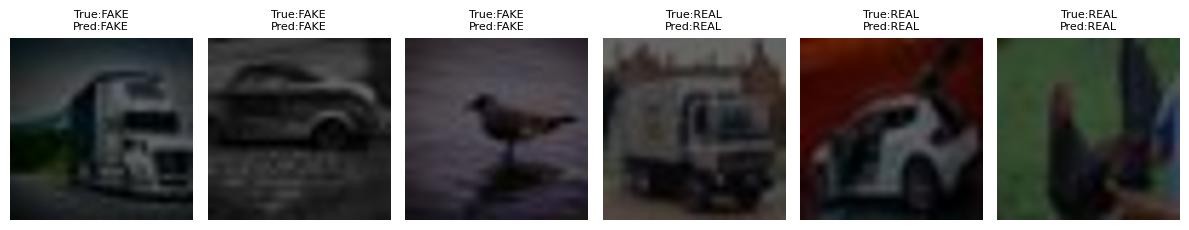

In [ ]:
#Ensure model allows gradients for GradCAM
for param in resnet18.parameters():
    param.requires_grad = True

from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt

#Setup GradCAM
cam_extractor = GradCAM(resnet18, target_layer='layer4')

#Overlay function
def overlay_mask(img_pil, mask_pil, alpha=0.6):
    img_pil = img_pil.resize(mask_pil.size).convert("RGBA")
    mask_pil = mask_pil.convert("RGBA").resize(img_pil.size)
    blended = Image.blend(img_pil, mask_pil, alpha=alpha)
    return blended

#Find 3 REAL and 3 FAKE indices
real_idxs, fake_idxs = [], []
for i, (path, label) in enumerate(test_vis_dataset.samples):
    if label == test_vis_dataset.class_to_idx['REAL'] and len(real_idxs) < 3:
        real_idxs.append(i)
    elif label == test_vis_dataset.class_to_idx['FAKE'] and len(fake_idxs) < 3:
        fake_idxs.append(i)
    if len(real_idxs) == 3 and len(fake_idxs) == 3:
        break

selected_idxs = fake_idxs + real_idxs  # 3 FAKE then 3 REAL

#Show GradCAM overlays
plt.figure(figsize=(12, 2.5))
for i, idx in enumerate(selected_idxs):
    img_path = test_vis_dataset.samples[idx][0]
    img = Image.open(img_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    resnet18.eval()
    out = resnet18(input_tensor)
    class_idx = out.squeeze().argmax().item()

    activation_map = cam_extractor(class_idx, out)
    cam_pil = to_pil_image(activation_map[0].cpu(), mode='F').resize((224,224))

    result = overlay_mask(img, cam_pil, alpha=0.6)

    plt.subplot(1, 6, i+1)
    plt.imshow(result)
    true_label = test_vis_dataset.classes[test_vis_dataset.samples[idx][1]]
    plt.title(f"True:{true_label}\nPred:{test_vis_dataset.classes[class_idx]}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Save ResNet18 model weights
torch.save(resnet18.state_dict(), "resnet18_cifake.pth")
print("ResNet18 model saved as resnet18_cifake.pth")

ResNet18 model saved as resnet18_cifake.pth


In [ ]:
import pickle

logs_resnet = {
    "train_losses": train_losses_resnet,
    "val_losses": val_losses_resnet,
    "train_accs": train_accs_resnet,
    "val_accs": val_accs_resnet
}

with open("resnet18_training_logs_cifake.pkl", "wb") as f:
    pickle.dump(logs_resnet, f)

print("ResNet18 training logs saved to resnet18_training_logs_cifake.pkl")

ResNet18 training logs saved to resnet18_training_logs_cifake.pkl


#VGG 16

In [ ]:
from torchvision import models
import torch.nn as nn

# Loading pretrained VGG16
vgg16 = models.vgg16(pretrained=True)

# Replace the classifier for 2 classes
vgg16.classifier[6] = nn.Linear(4096, 2)

vgg16 = vgg16.to(device)

# Freeze all features layers
for param in vgg16.features.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.5MB/s]


In [ ]:
import torch.optim as optim

# Only train the classifier parameters
params_to_update = [p for p in vgg16.parameters() if p.requires_grad]
criterion_vgg = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(params_to_update, lr=0.001)

In [ ]:
from tqdm.auto import tqdm

num_epochs_vgg = 5

train_losses_vgg, val_losses_vgg = [], []
train_accs_vgg, val_accs_vgg = [], []

for epoch in range(num_epochs_vgg):
    # Training
    vgg16.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs_vgg} [Train]"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer_vgg.zero_grad()
        outputs = vgg16(images)
        loss = criterion_vgg(outputs, labels)
        loss.backward()
        optimizer_vgg.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses_vgg.append(epoch_loss)
    train_accs_vgg.append(epoch_acc)

    # Validation
    vgg16.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs_vgg} [Val]"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = vgg16(images)
            loss = criterion_vgg(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses_vgg.append(val_epoch_loss)
    val_accs_vgg.append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs_vgg} | "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

Epoch 1/5 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 0.4029 Acc: 0.8409 | Val Loss: 0.2466 Acc: 0.9028


Epoch 2/5 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.3232 Acc: 0.8759 | Val Loss: 0.2586 Acc: 0.9063


Epoch 3/5 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.3115 Acc: 0.8824 | Val Loss: 0.2377 Acc: 0.9076


Epoch 4/5 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.3025 Acc: 0.8894 | Val Loss: 0.2328 Acc: 0.9060


Epoch 5/5 [Train]:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.2944 Acc: 0.8908 | Val Loss: 0.2507 Acc: 0.8966


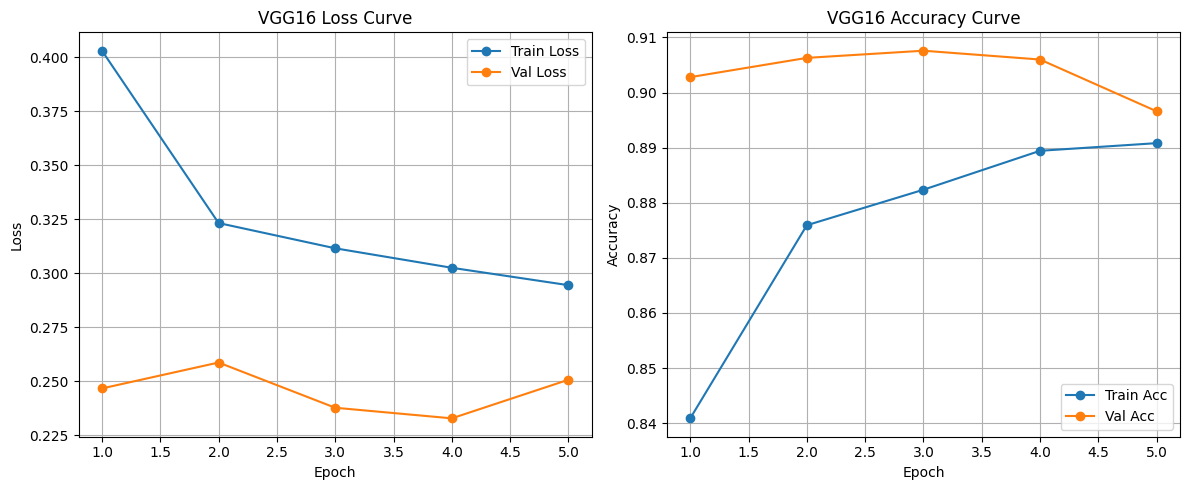

In [ ]:
import matplotlib.pyplot as plt

epochs_vgg = range(1, len(train_losses_vgg) + 1)

plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs_vgg, train_losses_vgg, marker='o', label='Train Loss')
plt.plot(epochs_vgg, val_losses_vgg, marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG16 Loss Curve')
plt.legend()
plt.grid(True)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs_vgg, train_accs_vgg, marker='o', label='Train Acc')
plt.plot(epochs_vgg, val_accs_vgg, marker='o', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGG16 Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

vgg16.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
all_preds_vgg, all_labels_vgg, all_probs_vgg = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)
        loss = criterion_vgg(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
        all_preds_vgg.extend(predicted.cpu().numpy())
        all_labels_vgg.extend(labels.cpu().numpy())
        all_probs_vgg.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

avg_test_loss_vgg = test_loss / test_total
test_acc_vgg = test_correct / test_total

print(f"\nVGG16 Test Loss: {avg_test_loss_vgg:.4f} | Test Accuracy: {test_acc_vgg:.4f}")
print("\nVGG16 Classification Report:")
print(classification_report(all_labels_vgg, all_preds_vgg, target_names=train_dataset.classes))

cm_vgg = confusion_matrix(all_labels_vgg, all_preds_vgg)
print("VGG16 Confusion Matrix:\n", cm_vgg)


VGG16 Test Loss: 0.2438 | Test Accuracy: 0.8980

VGG16 Classification Report:
              precision    recall  f1-score   support

        FAKE       0.95      0.84      0.89     10000
        REAL       0.86      0.95      0.90     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

VGG16 Confusion Matrix:
 [[8425 1575]
 [ 465 9535]]


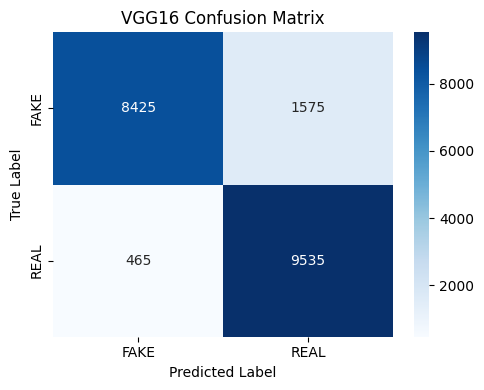

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('VGG16 Confusion Matrix')
plt.tight_layout()
plt.show()

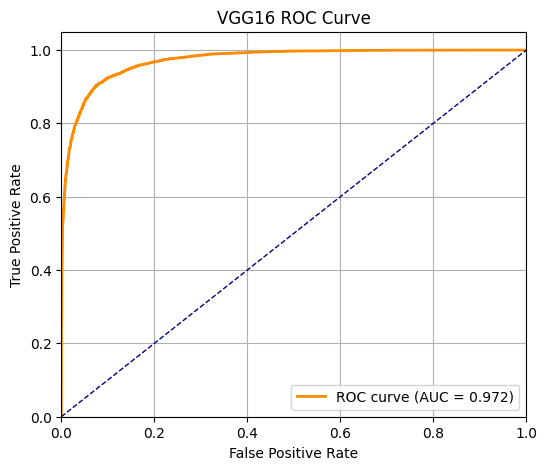

In [ ]:
fpr_vgg, tpr_vgg, _ = roc_curve(all_labels_vgg, all_probs_vgg)
roc_auc_vgg = auc(fpr_vgg, tpr_vgg)

plt.figure(figsize=(6,5))
plt.plot(fpr_vgg, tpr_vgg, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_vgg:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16 ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

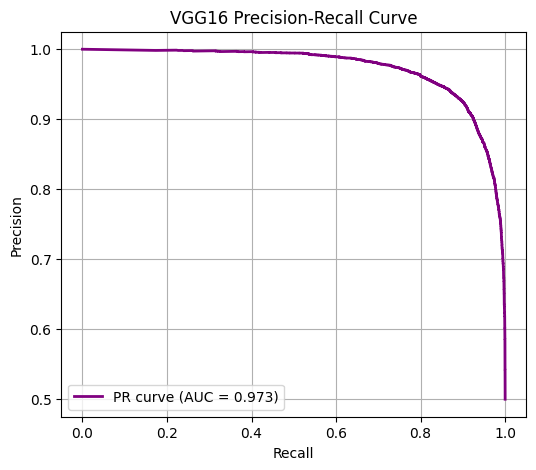

In [ ]:
precision_vgg, recall_vgg, _ = precision_recall_curve(all_labels_vgg, all_probs_vgg)
pr_auc_vgg = average_precision_score(all_labels_vgg, all_probs_vgg)

plt.figure(figsize=(6,5))
plt.plot(recall_vgg, precision_vgg, color='purple', lw=2, label=f'PR curve (AUC = {pr_auc_vgg:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('VGG16 Precision-Recall Curve')
plt.legend(loc="best")
plt.grid(True)
plt.show()

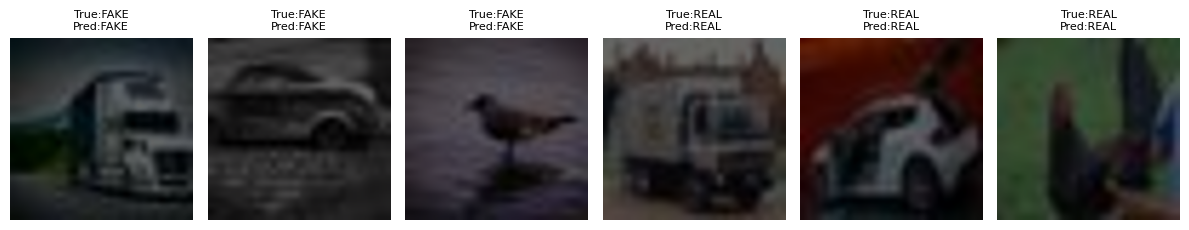

In [ ]:
# Ensure gradients are enabled for GradCAM
for param in vgg16.parameters():
    param.requires_grad = True

from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt

# Setup GradCAM for VGG16 (last conv layer is 'features.29')
cam_extractor = GradCAM(vgg16, target_layer='features.29')

def overlay_mask(img_pil, mask_pil, alpha=0.6):
    img_pil = img_pil.resize(mask_pil.size).convert("RGBA")
    mask_pil = mask_pil.convert("RGBA").resize(img_pil.size)
    blended = Image.blend(img_pil, mask_pil, alpha=alpha)
    return blended

# Find 3 REAL and 3 FAKE indices
real_idxs, fake_idxs = [], []
for i, (path, label) in enumerate(test_vis_dataset.samples):
    if label == test_vis_dataset.class_to_idx['REAL'] and len(real_idxs) < 3:
        real_idxs.append(i)
    elif label == test_vis_dataset.class_to_idx['FAKE'] and len(fake_idxs) < 3:
        fake_idxs.append(i)
    if len(real_idxs) == 3 and len(fake_idxs) == 3:
        break

selected_idxs = fake_idxs + real_idxs

# Show GradCAM overlays for VGG16
plt.figure(figsize=(12, 2.5))
for i, idx in enumerate(selected_idxs):
    img_path = test_vis_dataset.samples[idx][0]
    img = Image.open(img_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    vgg16.eval()
    out = vgg16(input_tensor)
    class_idx = out.squeeze().argmax().item()

    activation_map = cam_extractor(class_idx, out)
    cam_pil = to_pil_image(activation_map[0].cpu(), mode='F').resize((224,224))

    result = overlay_mask(img, cam_pil, alpha=0.6)

    plt.subplot(1, 6, i+1)
    plt.imshow(result)
    true_label = test_vis_dataset.classes[test_vis_dataset.samples[idx][1]]
    plt.title(f"True:{true_label}\nPred:{test_vis_dataset.classes[class_idx]}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
torch.save(vgg16.state_dict(), "vgg16_cifake.pth")
print("VGG16 model saved as vgg16_cifake.pth")

import pickle
logs_vgg = {
    "train_losses": train_losses_vgg,
    "val_losses": val_losses_vgg,
    "train_accs": train_accs_vgg,
    "val_accs": val_accs_vgg
}
with open("vgg16_training_logs_cifake.pkl", "wb") as f:
    pickle.dump(logs_vgg, f)
print("VGG16 training logs saved to vgg16_training_logs_cifake.pkl")

VGG16 model saved as vgg16_cifake.pth
VGG16 training logs saved to vgg16_training_logs_cifake.pkl


In [ ]:
from google.colab import files
files.download('vgg16_cifake.pth')
files.download('resnet18_cifake.pth')
files.download('custom_cnn_cifake.pth')
# And for logs:
files.download('vgg16_training_logs_cifake.pkl')
files.download('resnet18_training_logs_cifake.pkl')
files.download('training_logs_cifake.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

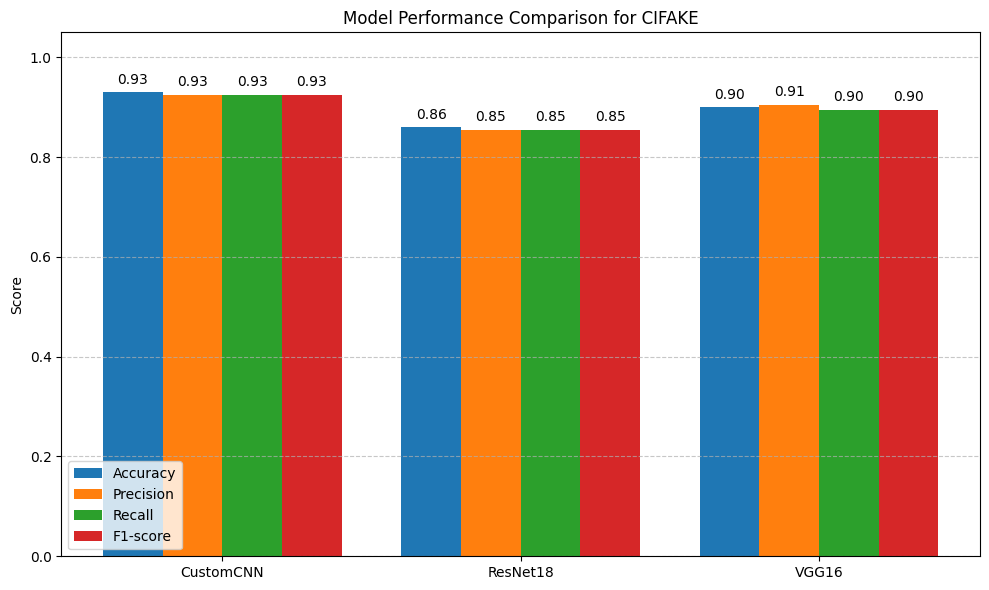

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['CustomCNN', 'ResNet18', 'VGG16']

accuracy  = [0.93, 0.86, 0.90]
precision = [0.925, 0.855, 0.905]
recall    = [0.925, 0.855, 0.895]
f1        = [0.925, 0.855, 0.895]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
bars2 = ax.bar(x - 0.5*width, precision, width, label='Precision')
bars3 = ax.bar(x + 0.5*width, recall, width, label='Recall')
bars4 = ax.bar(x + 1.5*width, f1, width, label='F1-score')

for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_title("Model Performance Comparison for CIFAKE")
ax.legend(loc='lower left')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()